# 🛍️ Customer Spending Analysis (Online Retail II)

This notebook loads the **UCI Online Retail II** dataset, performs cleaning, exploratory analysis, and RFM-based customer segmentation. It is written to be **robust** to minor column-name differences in various copies of the dataset.

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

print('Pandas version:', pd.__version__)

Pandas version: 2.3.3


## Load data

In [2]:
DEFAULT_PATH = Path('../data/online_retail_II.xlsx')
FILE_PATH = Path(os.environ.get('ONLINE_RETAIL_PATH', DEFAULT_PATH))

if not FILE_PATH.exists():
    raise FileNotFoundError(f"Dataset not found at {FILE_PATH.resolve()}\n"
                            "Set env var ONLINE_RETAIL_PATH to the file, or move the file to ../data/online_retail_II.xlsx")

try_sheets = ['Year 2010-2011', 0]

last_err = None
for sheet in try_sheets:
    try:
        df = pd.read_excel(FILE_PATH, sheet_name=sheet)
        break
    except Exception as e:
        last_err = e
else:
    raise last_err

print(f"Loaded shape: {df.shape}")
df.head()

Loaded shape: (541910, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Normalize columns & basic cleaning

In [3]:
# Normalize known column variants
rename_map = {
    'InvoiceNo': 'Invoice',
    'UnitPrice': 'Price',
    'CustomerID': 'Customer ID',
}
df.rename(columns={k:v for k,v in rename_map.items() if k in df.columns}, inplace=True)

# Ensure expected columns exist
expected = ['Invoice','StockCode','Description','Quantity','InvoiceDate','Price','Customer ID','Country']
missing = [c for c in expected if c not in df.columns]
if missing:
    raise KeyError(f"Missing expected columns: {missing}. Found columns: {list(df.columns)}")

In [4]:
# Drop rows without customer id
df = df.dropna(subset=['Customer ID'])

# Remove cancelled invoices (start with 'C')
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Keep only positive quantity and price
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# Revenue
df['Revenue'] = df['Quantity'] * df['Price']

# Datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df = df.dropna(subset=['InvoiceDate'])

df.describe(include='all')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Revenue
count,397885.0,397885,397885,397885.000000,397885,397885.000000,397885.000000,397885,397885.000000
unique,18532.0,3665,3877,NaN,NaN,NaN,NaN,37,NaN
top,576339.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom,NaN
freq,542.0,2035,2028,NaN,NaN,NaN,NaN,354321,NaN
mean,NaN,NaN,NaN,12.988208,2011-07-10 23:41:56.419316992,3.116525,15294.416882,NaN,22.396989
min,NaN,NaN,NaN,1.000000,2010-12-01 08:26:00,0.001000,12346.000000,NaN,0.001000
25%,NaN,NaN,NaN,2.000000,2011-04-07 11:12:00,1.250000,13969.000000,NaN,4.680000
50%,NaN,NaN,NaN,6.000000,2011-07-31 14:39:00,1.950000,15159.000000,NaN,11.800000
75%,NaN,NaN,NaN,12.000000,2011-10-20 14:33:00,3.750000,16795.000000,NaN,19.800000
max,NaN,NaN,NaN,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,NaN,168469.600000


## Feature engineering & aggregates

In [5]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()

# Aggregates
monthly_revenue = df.groupby(['Year','Month'], as_index=False)['Revenue'].sum()
country_revenue = df.groupby('Country', as_index=False)['Revenue'].sum().sort_values('Revenue', ascending=False)
top_products = df.groupby('Description', as_index=False)['Revenue'].sum().sort_values('Revenue', ascending=False).head(10)

monthly_revenue.head(), country_revenue.head(), top_products.head()

(   Year  Month     Revenue
 0  2010     12  572713.890
 1  2011      1  569445.040
 2  2011      2  447137.350
 3  2011      3  595500.760
 4  2011      4  469200.361,
            Country      Revenue
 35  United Kingdom  7308391.554
 23     Netherlands   285446.340
 10            EIRE   265545.900
 14         Germany   228867.140
 13          France   209042.050,
                              Description    Revenue
 2319         PAPER CRAFT , LITTLE BIRDIE  168469.60
 2767            REGENCY CAKESTAND 3 TIER  142592.95
 3698  WHITE HANGING HEART T-LIGHT HOLDER  100448.15
 1762             JUMBO BAG RED RETROSPOT   85220.78
 1992      MEDIUM CERAMIC TOP STORAGE JAR   81416.73)

## Visualizations

In [6]:
fig1 = px.line(monthly_revenue, x='Month', y='Revenue', color='Year', title='Monthly Revenue Trend')
fig1.show()

fig2 = px.bar(country_revenue.head(10), x='Country', y='Revenue', title='Top 10 Countries by Revenue')
fig2.show()

fig3 = px.bar(top_products, x='Revenue', y='Description', orientation='h', title='Top 10 Products by Revenue')
fig3.show()

## RFM computation

In [7]:
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = (
    df.groupby('Customer ID')
      .agg({
          'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
          'Invoice': 'nunique',                                # Frequency
          'Revenue': 'sum'                                     # Monetary
      })
      .rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'Revenue': 'Monetary'})
      .reset_index()
)

rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


## RFM scoring & segmentation

In [8]:
# Quantile-based scoring
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)   # lower recency -> higher score
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

def segment_customer(score: int) -> str:
    if score >= 13:
        return 'Champions'
    elif score >= 10:
        return 'Loyal Customers'
    elif score >= 7:
        return 'Potential Loyalist'
    elif score >= 5:
        return 'At Risk'
    else:
        return 'Lost'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)
rfm['Segment'].value_counts()

Segment
Potential Loyalist    1092
Loyal Customers       1008
Champions              934
At Risk                759
Lost                   545
Name: count, dtype: int64

## Segment visualizations

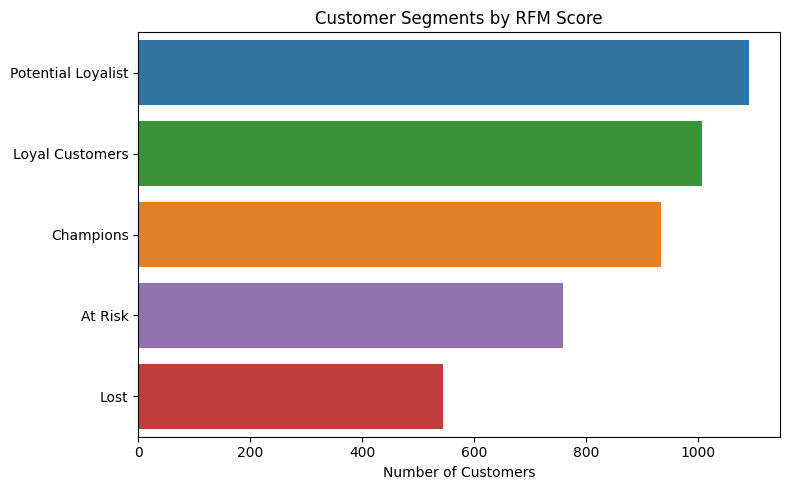

In [9]:
plt.figure(figsize=(8,5))
# Avoid seaborn future warning by using hue
sns.countplot(data=rfm, y='Segment', hue='Segment', order=rfm['Segment'].value_counts().index, legend=False)
plt.title('Customer Segments by RFM Score')
plt.xlabel('Number of Customers')
plt.ylabel('')
plt.tight_layout()
plt.show()

fig4 = px.histogram(rfm, x='Segment', color='Segment', title='Customer Segments (RFM)')
fig4.update_layout(xaxis_title='Segment', yaxis_title='Count')
fig4.show()

segment_summary = (
    df.merge(rfm[['Customer ID','Segment']], on='Customer ID')
      .groupby('Segment', as_index=False)['Revenue'].sum()
      .sort_values('Revenue', ascending=False)
)

fig5 = px.bar(segment_summary, x='Segment', y='Revenue', color='Segment', title='Total Revenue by Segment')
fig5.show()

## Save outputs

In [10]:
out_dir = Path('../outputs')
out_dir.mkdir(parents=True, exist_ok=True)

rfm.to_csv(out_dir / 'customer_rfm_summary.csv', index=False)
segment_summary.to_csv(out_dir / 'segment_revenue.csv', index=False)

print('Saved:', [p.name for p in out_dir.glob('*.csv')])

Saved: ['customer_behavior_clusters.csv', 'customer_behavior_predictions.csv', 'customer_rfm_summary.csv', 'segment_revenue.csv']


In [11]:
# Behaviour prediction with k-means clustering
import pandas as pd

rfm = pd.read_csv('../outputs/customer_rfm_summary.csv')
rfm.head()

,Customer ID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346.0,326,1,77183.60,1,1,5,7,Potential Loyalist
1,12347.0,2,7,4310.00,5,5,5,15,Champions
2,12348.0,75,4,1797.24,2,4,4,10,Loyal Customers
3,12349.0,19,1,1757.55,4,1,4,9,Potential Loyalist
4,12350.0,310,1,334.40,1,1,2,4,Lost


In [12]:
rfm['Active'] = rfm['Segment'].apply(lambda x: 1 if x in ['Champions', 'Loyal Customers'] else 0)
rfm[['Segment', 'Active']].head()

,Segment,Active
0,Potential Loyalist,0
1,Champions,1
2,Loyal Customers,1
3,Potential Loyalist,0
4,Lost,0


In [13]:
X = rfm[['Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score']]
y = rfm['Active']

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       599
           1       1.00      1.00      1.00       486

    accuracy                           1.00      1085
   macro avg       1.00      1.00      1.00      1085
weighted avg       1.00      1.00      1.00      1085



In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       599
           1       1.00      1.00      1.00       486

    accuracy                           1.00      1085
   macro avg       1.00      1.00      1.00      1085
weighted avg       1.00      1.00      1.00      1085



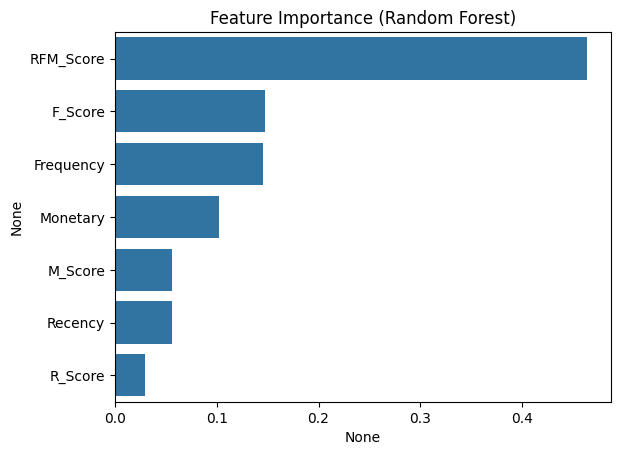

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance (Random Forest)")
plt.show()

In [20]:
rfm['Predicted_Active'] = rf.predict(X)
rfm.to_csv('../outputs/customer_behavior_predictions.csv', index=False)

In [21]:
# XGBoost/ LightBGM Behaviour Prediction
first_purchase = df.groupby('Customer ID')['InvoiceDate'].min().reset_index()
first_purchase.columns = ['Customer ID', 'FirstPurchaseDate']

rfm = rfm.merge(first_purchase, on='Customer ID', how='left')
rfm['FirstPurchaseDate'] = pd.to_datetime(rfm['FirstPurchaseDate'])

# Compute number of days since first purchase relative to last transaction
rfm['Time_Since_First'] = (ref_date - rfm['FirstPurchaseDate']).dt.days

rfm[['Customer ID', 'Recency', 'Frequency', 'Monetary', 'Time_Since_First']].head()

,Customer ID,Recency,Frequency,Monetary,Time_Since_First
0,12346.0,326,1,77183.60,326
1,12347.0,2,7,4310.00,367
2,12348.0,75,4,1797.24,358
3,12349.0,19,1,1757.55,19
4,12350.0,310,1,334.40,310


In [22]:
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Add new feature
features = ['Recency', 'Frequency', 'Monetary', 'RFM_Score', 'Time_Since_First']
X = rfm[features]
y = rfm['Active']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# LightGBM
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgb))
print("\nXGBoost Report:\n", classification_report(y_test, y_pred_xgb))

[LightGBM] [Info] Number of positive: 1456, number of negative: 1797
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 782
[LightGBM] [Info] Number of data points in the train set: 3253, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.447587 -> initscore=-0.210426
[LightGBM] [Info] Start training from score -0.210426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select numeric features
cluster_features = rfm[['Recency', 'Frequency', 'Monetary', 'Time_Since_First']]

# Scale features
scaler = StandardScaler()
scaled = scaler.fit_transform(cluster_features)

# Train K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(scaled)

# ✅ Check if 'Cluster' column now exists
print(rfm.columns)

Index(['Customer ID', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score',
       'M_Score', 'RFM_Score', 'Segment', 'Active', 'Predicted_Active',
       'FirstPurchaseDate', 'Time_Since_First', 'Cluster'],
      dtype='object')


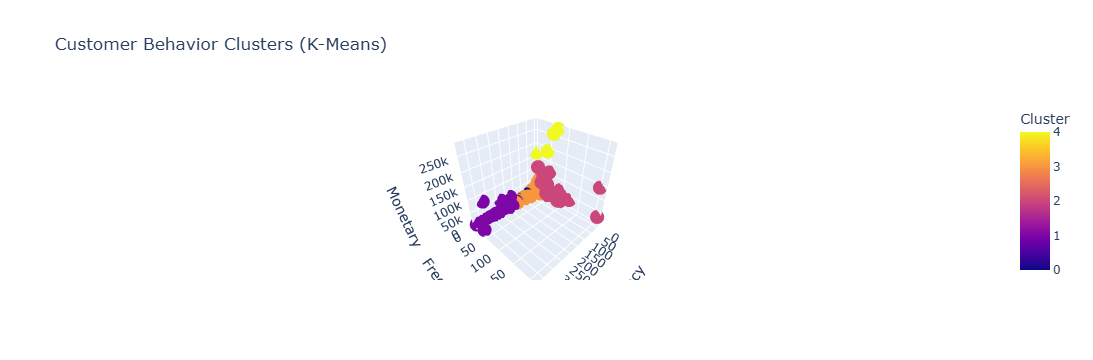

In [29]:
import plotly.express as px

fig = px.scatter_3d(
    rfm, 
    x='Recency', y='Frequency', z='Monetary', 
    color='Cluster', title='Customer Behavior Clusters (K-Means)',
    hover_data=['Customer ID']
)
fig.show()

In [30]:
rfm.to_csv('../outputs/customer_behavior_clusters.csv', index=False)